In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(46)

from matplotlib import style
style.use('fivethirtyeight')

In [3]:
data_dir = ' '
train_path = 'Train'
test_path = 'Test'

# Resizing the images to 30x30x3
IMAGE_HEIGHT = 30
IMAGE_WIDTH = 30
channels = 3

In [4]:
test_csv_df = pd.read_csv('Test.csv')
train_csv_df = pd.read_csv('Train.csv')
print(train_csv_df.isnull().sum())
print(test_csv_df.isnull().sum())

Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64
Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64


In [5]:
number_categories = len(os.listdir(train_path))
print('Number of Categories in the dataset: ', number_categories)

Number of Categories in the dataset:  43


In [6]:
classes = { 0:'Speed limit of 20km/h',
            1:'Speed limit of 30km/h', 
            2:'Speed limit of 50km/h', 
            3:'Speed limit of 60km/h', 
            4:'Speed limit of 70km/h', 
            5:'Speed limit of 80km/h', 
            6:'End of speed limit of 80km/h', 
            7:'Speed limit of 100km/h', 
            8:'Speed limit of 120km/h', 
            9:'No passing', 
            10:'No passing vehicle over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Vehicle > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing vehicle > 3.5 tons' }

In [7]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

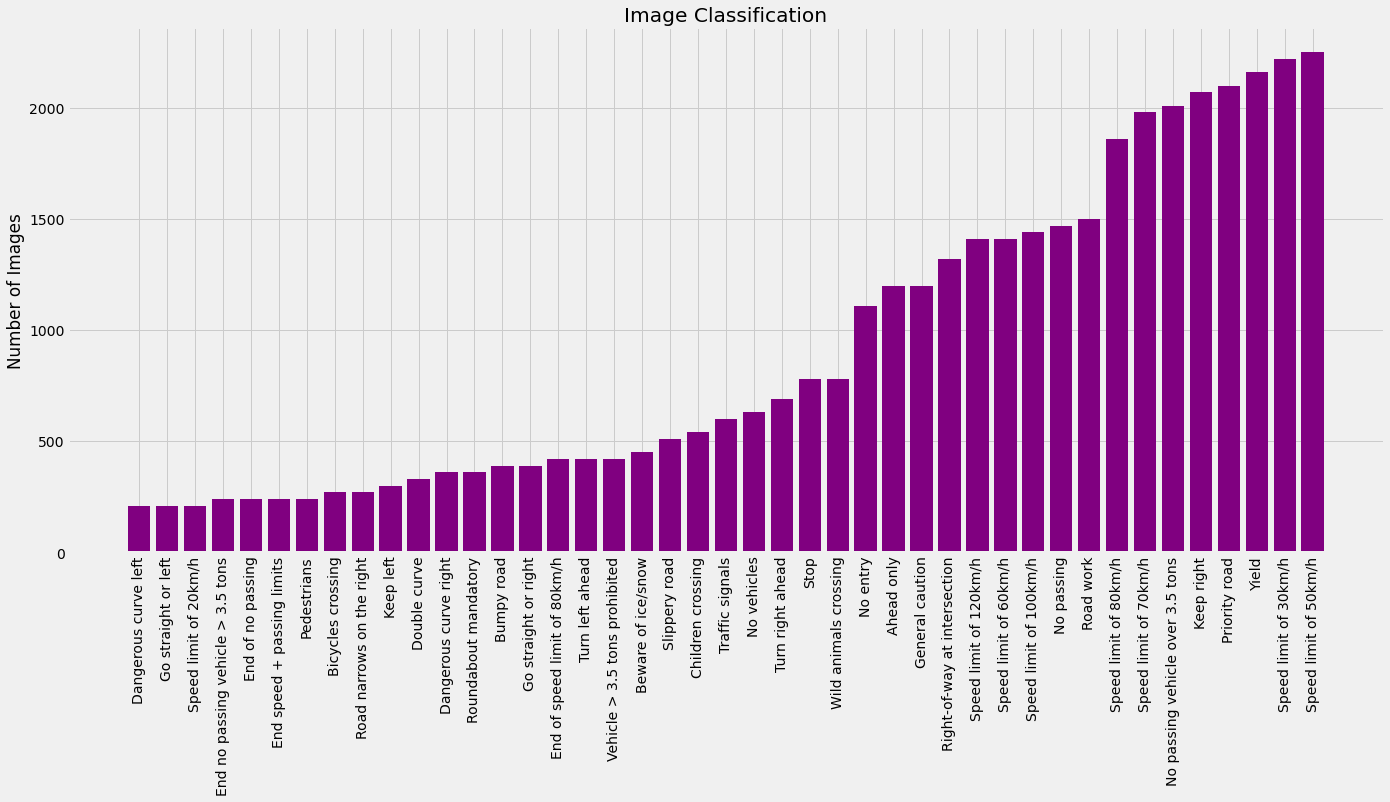

In [7]:
plt.figure(figsize=(21,9))  
plt.bar(class_num, train_number,color = 'purple')
plt.xticks(class_num, rotation='vertical')
plt.ylabel("Number of Images")
plt.title("Image Classification")
plt.show()


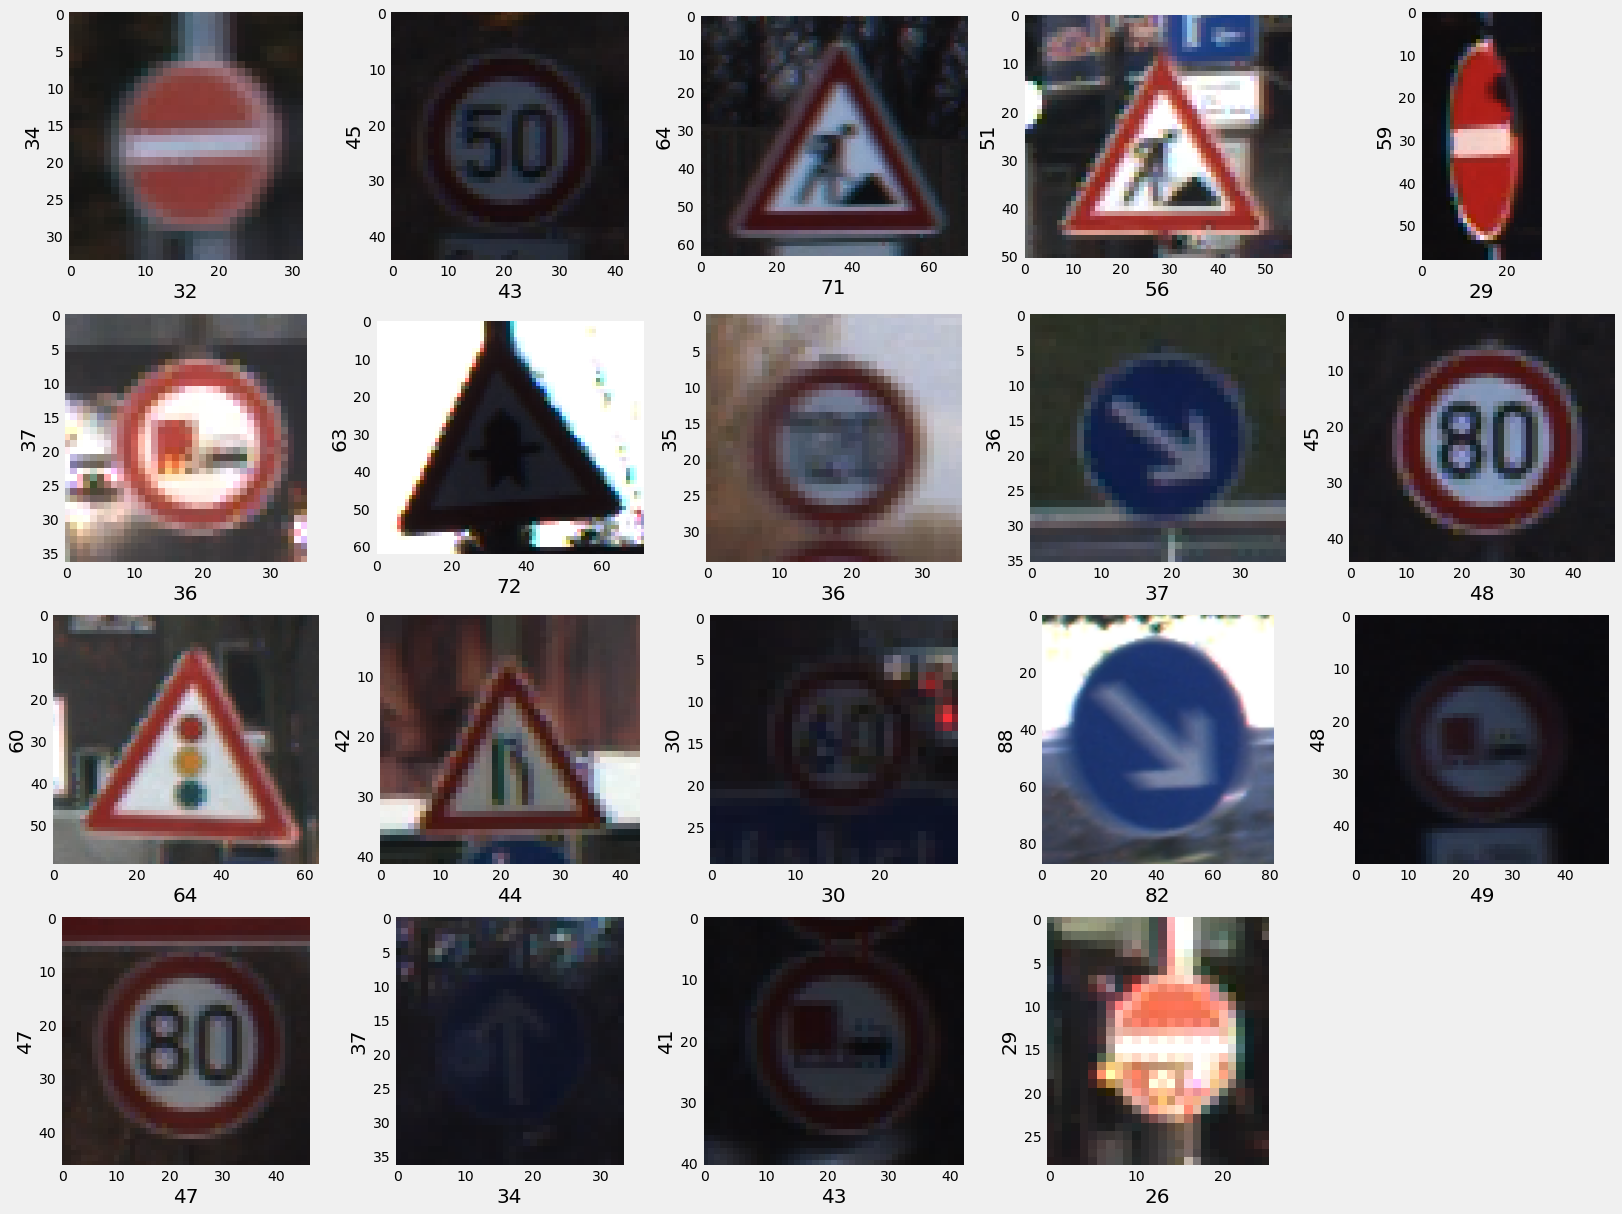

In [8]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv('Test.csv')
imgs = test["Path"].values
plt.figure(figsize=(25,25))

for i in range(1,20):
    plt.subplot(5,5,i)
    random_img_path = random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [9]:
image_data = []
image_labels = []

for i in range(number_categories):
    
    path =  'Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMAGE_HEIGHT, IMAGE_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [19]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [20]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [21]:
y_train = keras.utils.to_categorical(y_train, number_categories)
y_val = keras.utils.to_categorical(y_val, number_categories)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [22]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,channels)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [24]:
lr = 0.001
epochs = 30

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [25]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history= model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
858/858 [==============================] - 88s 102ms/step - loss: 0.8474 - accuracy: 0.7714 - val_loss: 0.0459 - val_accuracy: 0.9867
Epoch 2/30
858/858 [==============================] - 98s 115ms/step - loss: 0.1311 - accuracy: 0.9597 - val_loss: 0.0174 - val_accuracy: 0.9950
Epoch 3/30
858/858 [==============================] - 100s 116ms/step - loss: 0.0826 - accuracy: 0.9750 - val_loss: 0.0326 - val_accuracy: 0.9901
Epoch 4/30
858/858 [==============================] - 97s 114ms/step - loss: 0.0599 - accuracy: 0.9816 - val_loss: 0.0242 - val_accuracy: 0.9916
Epoch 5/30
858/858 [==============================] - 94s 110ms/step - loss: 0.0587 - accuracy: 0.9819 - val_loss: 0.0192 - val_accuracy: 0.9941
Epoch 6/30
858/858 [==============================] - 94s 109ms/step - loss: 0.0476 - accuracy: 0.9856 - val_loss: 0.0215 - val_accuracy: 0.9935
Epoch 7/30
858/858 [==============================] - 95s 111ms/step - loss: 0.0392 - accuracy: 0.9876 - val_loss: 0.0125 - val_a

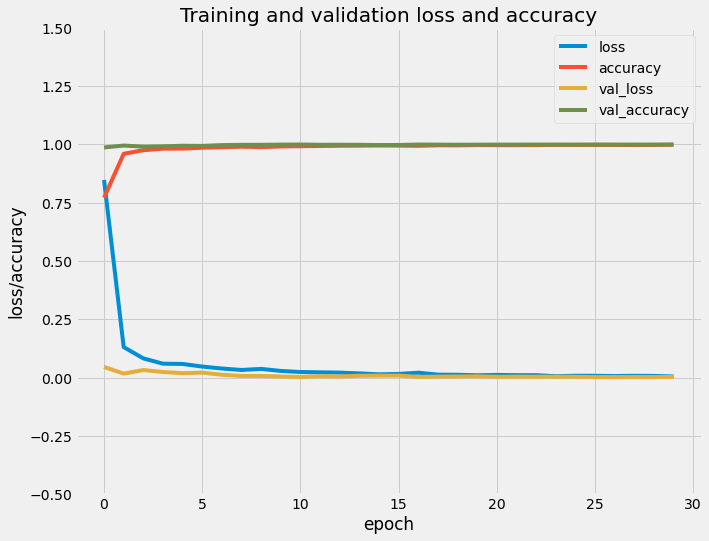

In [26]:
pd.DataFrame(history.history).plot(figsize=(10, 8))
plt.grid(True)
plt.gca().set_ylim(-0.5, 1.5)
plt.title("Training and validation loss and accuracy")
plt.ylabel('loss/accuracy')
plt.xlabel('epoch')
plt.show()

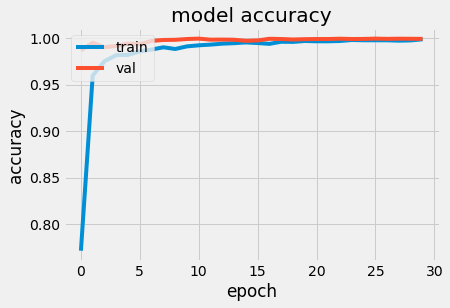

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

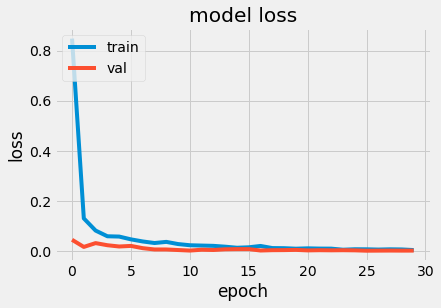

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
test = pd.read_csv('Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMAGE_HEIGHT, IMAGE_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = model.predict_classes(X_test)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  98.5827395091053


In [31]:
!pip install visualkeras
import visualkeras

  Using cached visualkeras-0.0.2-py3-none-any.whl (12 kB)
  Using cached aggdraw-1.3.12-cp38-cp38-win_amd64.whl (42 kB)


In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 9, 256)         295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 256)        

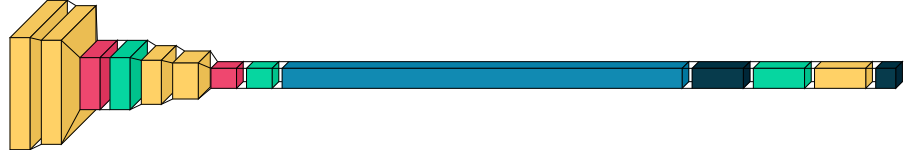

In [33]:
visualkeras.layered_view(model)

In [34]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        60
           1       0.99      1.00      1.00       720
           2       0.98      1.00      0.99       750
           3       0.99      0.97      0.98       450
           4       1.00      1.00      1.00       660
           5       0.98      1.00      0.99       630
           6       1.00      0.99      1.00       150
           7       0.99      1.00      1.00       450
           8       1.00      0.97      0.98       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.95      0.95      0.95       420
          12       1.00      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00    